In [259]:
import yfinance as yf
# Define the time range
aapl = yf.Ticker("AAPL")
# Fetch historical data since 2006
aapl_data = aapl.history(start="2010-10-29", end=None)
aapl_data = aapl_data[['Open', 'High', 'Low', 'Close', 'Volume']]
# Show the first few rows
print(aapl_data.head())
# Save it to a CSV file
aapl_data.to_csv("aapl_data.csv")

                               Open      High       Low     Close     Volume
Date                                                                        
2010-10-29 00:00:00-04:00  9.165441  9.215150  9.064214  9.067529  430511200
2010-11-01 00:00:00-04:00  9.104890  9.206719  9.104288  9.163939  423889200
2010-11-02 00:00:00-04:00  9.248890  9.344994  9.248890  9.319988  433930000
2010-11-03 00:00:00-04:00  9.380545  9.426037  9.294986  9.423627  508348400
2010-11-04 00:00:00-04:00  9.503462  9.645962  9.490809  9.588420  642488000


### Creamos métricas para el entrenamiento

In [260]:
import pandas as pd
import numpy as np
data = pd.read_csv('aapl_data.csv')

#Estandarizamos fecha y precio
data['Close'] = data['Close'].astype(float)  
data['Date'] = pd.to_datetime(data['Date'])  

# Calculamos métricas

# SMA_Ratio: Relación entre precio de cierre y promedio móvil simple (20 días)
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_Ratio'] = data['Close'] / data['SMA_20']

# MACD_hist: Histograma de MACD
ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = ema_12 - ema_26
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['MACD_hist'] = data['MACD'] - data['Signal_Line']

# RSI (Relative Strength Index, 14 días)
delta = data['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

# SO_diff: Diferencia del oscilador estocástico
low_14 = data['Close'].rolling(window=14).min()
high_14 = data['Close'].rolling(window=14).max()
data['%K'] = (data['Close'] - low_14) / (high_14 - low_14) * 100
data['%D'] = data['%K'].rolling(window=3).mean()
data['SO_diff'] = data['%K'] - data['%D']

# Returns: Retorno logarítmico diario
data['Returns'] = np.log(data['Close'] / data['Close'].shift(1))

# Exportar o continuar trabajando con el DataFrame resultante
data.to_csv('aapl_data_with_metrics.csv', index=False)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_5064\2927819463.py:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['Date'] = pd.to_datetime(data['Date'])


In [261]:
data_metrics= pd.read_csv('aapl_data_with_metrics.csv')
print(data.tail())

                           Date        Open        High         Low  \
3538  2024-11-20 00:00:00-05:00  228.059998  229.929993  225.889999   
3539  2024-11-21 00:00:00-05:00  228.880005  230.160004  225.710007   
3540  2024-11-22 00:00:00-05:00  228.059998  230.720001  228.059998   
3541  2024-11-25 00:00:00-05:00  231.460007  233.250000  229.740005   
3542  2024-11-26 00:00:00-05:00  233.475006  235.570007  233.475006   

           Close    Volume      SMA_20  SMA_Ratio      MACD  Signal_Line  \
3538  229.000000  35169600  226.996926   1.008824 -0.198379    -0.494513   
3539  228.520004  42108300  226.907095   1.007108 -0.065097    -0.408630   
3540  229.869995  38168300  226.842811   1.013345  0.147760    -0.297352   
3541  232.869995  90152800  226.829136   1.026632  0.552161    -0.127449   
3542  235.020004  28912459  226.909476   1.035743  1.034217     0.104884   

      MACD_hist        RSI         %K          %D   SO_diff   Returns  
3538   0.296134  56.669050  100.00000   92.4

In [262]:
df = data_metrics.drop(columns = ['Open', 'High', 'Low', 'Volume','SMA_20','MACD','Signal_Line','%K', '%D'])
df = df.dropna()
df.head()

,Date,Close,SMA_Ratio,MACD_hist,RSI,SO_diff,Returns
19,2010-11-26 00:00:00-05:00,9.489907,1.013463,0.003815,47.898201,11.902191,0.000635
20,2010-11-29 00:00:00-05:00,9.546243,1.016880,0.011837,48.286053,9.274231,0.005919
21,2010-11-30 00:00:00-05:00,9.373919,0.997408,0.004739,45.454678,-17.299724,-0.018216
22,2010-12-01 00:00:00-05:00,9.532083,1.013094,0.009617,48.583202,13.374279,0.016732
23,2010-12-02 00:00:00-05:00,9.584803,1.017826,0.014994,51.295230,14.039518,0.005516


### Splitting into Training and Testing Set And Quantile Binning

In [263]:

train_df= df.iloc[:2500]
test_df= df.iloc[2500:]

In [264]:
num_bins = 11
states = num_bins**5 * 3
states

483153

*Action Space* (simple)

* go/stay short, neutral, long

In [265]:
states * 3

1449459

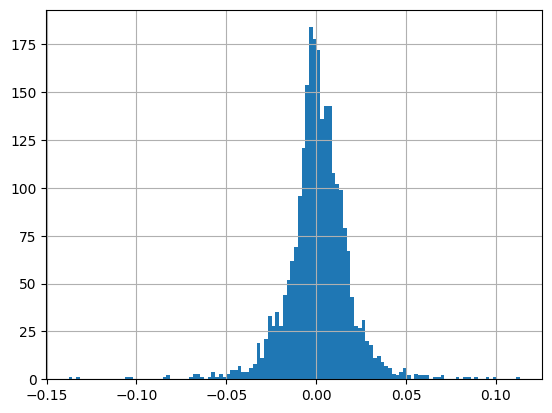

In [266]:
import matplotlib.pyplot as plt
train_df.Returns.hist(bins = 120)
plt.show()

In [267]:
train_df['Returns_binned'], bin_edges = pd.qcut(train_df['Returns'], q= num_bins, labels= False, retbins = True, duplicates= 'drop')
train_df

C:\Users\Usuario\AppData\Local\Temp\ipykernel_5064\1294770202.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Returns_binned'], bin_edges = pd.qcut(train_df['Returns'], q= num_bins, labels= False, retbins = True, duplicates= 'drop')


,Date,Close,SMA_Ratio,MACD_hist,RSI,SO_diff,Returns,Returns_binned
19,2010-11-26 00:00:00-05:00,9.489907,1.013463,0.003815,47.898201,11.902191,0.000635,5
20,2010-11-29 00:00:00-05:00,9.546243,1.016880,0.011837,48.286053,9.274231,0.005919,7
21,2010-11-30 00:00:00-05:00,9.373919,0.997408,0.004739,45.454678,-17.299724,-0.018216,1
22,2010-12-01 00:00:00-05:00,9.532083,1.013094,0.009617,48.583202,13.374279,0.016732,9
23,2010-12-02 00:00:00-05:00,9.584803,1.017826,0.014994,51.295230,14.039518,0.005516,6
...,...,...,...,...,...,...,...,...
2514,2020-10-26 00:00:00-04:00,112.308464,0.983750,-0.434372,53.926091,-12.690612,0.000087,5
2515,2020-10-27 00:00:00-04:00,113.821533,0.995934,-0.376097,53.206823,5.665443,0.013382,8
2516,2020-10-28 00:00:00-04:00,108.550209,0.951684,-0.662716,43.497784,-6.044665,-0.047419,0
2517,2020-10-29 00:00:00-04:00,112.572014,0.987565,-0.555908,47.348119,15.046177,0.036380,10


In [268]:
train_df.Returns_binned.value_counts().sort_index()
bin_edges

array([-0.13770801, -0.01965434, -0.01067705, -0.0060688 , -0.0030822 ,
       -0.00040388,  0.00220703,  0.005851  ,  0.00896808,  0.01370307,
        0.02011475,  0.11315756])

In [269]:
test_df['Returns_binned'], bin_edges = pd.cut(test_df['Returns'], bins= np.concatenate(([-np.inf], bin_edges[1:-1],[np.inf])),labels= False, retbins = True, duplicates= 'drop')
test_df

C:\Users\Usuario\AppData\Local\Temp\ipykernel_5064\3655227595.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Returns_binned'], bin_edges = pd.cut(test_df['Returns'], bins= np.concatenate(([-np.inf], bin_edges[1:-1],[np.inf])),labels= False, retbins = True, duplicates= 'drop')


,Date,Close,SMA_Ratio,MACD_hist,RSI,SO_diff,Returns,Returns_binned
2519,2020-11-02 00:00:00-05:00,106.178085,0.936240,-1.022182,27.107228,-10.404000,-0.000827,4
2520,2020-11-03 00:00:00-05:00,107.808311,0.951728,-0.961866,31.146947,9.324501,0.015237,9
2521,2020-11-04 00:00:00-05:00,112.210838,0.990649,-0.589864,41.149341,35.532888,0.040025,10
2522,2020-11-05 00:00:00-05:00,116.193619,1.024020,-0.067447,50.014309,41.906847,0.034878,10
2523,2020-11-06 00:00:00-05:00,116.061600,1.022010,0.259418,54.550704,12.357002,-0.001137,4
...,...,...,...,...,...,...,...,...
3538,2024-11-20 00:00:00-05:00,229.000000,1.008824,0.296134,56.669050,7.536574,0.003149,6
3539,2024-11-21 00:00:00-05:00,228.520004,1.007108,0.343533,63.004489,-4.423520,-0.002098,4
3540,2024-11-22 00:00:00-05:00,229.869995,1.013345,0.445112,67.646248,2.211760,0.005890,7
3541,2024-11-25 00:00:00-05:00,232.869995,1.026632,0.679610,69.706403,2.211760,0.012966,8


In [270]:
test_df.Returns_binned.value_counts().sort_index()

Returns_binned
0     103
1     102
2     108
3      82
4      78
5      78
6     107
7      85
8      83
9      92
10    106
Name: count, dtype: int64

In [271]:

features= ["SMA_Ratio",	"MACD_hist","RSI",	"SO_diff",	"Returns"]
features


['SMA_Ratio', 'MACD_hist', 'RSI', 'SO_diff', 'Returns']

In [272]:
bin_edges_list = []  # Inicializa la lista de bordes

# Generar bins en train_df
for feature in features:
    train_df[f'{feature}_binned'], bin_edges = pd.qcut(
        train_df[feature], 
        q=num_bins, 
        labels=False, 
        retbins=True, 
        duplicates='drop'
    )
    bin_edges_list.append(bin_edges)  # Guarda los bordes
    print(f"Bordes para {feature}: {bin_edges}")  # Verifica los bordes


Bordes para SMA_Ratio: [0.83197052 0.95108167 0.97491358 0.9889342  0.99919777 1.00852833
 1.01642565 1.02564177 1.03510969 1.04809519 1.06195811 1.14749357]
Bordes para MACD_hist: [-2.45703443 -0.21011015 -0.11260434 -0.06617427 -0.03270106 -0.00753213
  0.01701499  0.04630996  0.08154853  0.1271467   0.21640247  1.50402575]
Bordes para RSI: [ 8.21286023 32.04301081 39.23229952 44.35066145 49.11451925 53.94163594
 59.26808574 64.12207269 69.12016604 73.81693445 81.61590516 97.39778711]
Bordes para SO_diff: [-63.2226038  -18.61727231 -10.01700745  -5.52474143  -2.33267266
   0.           0.24902352   2.33561714   5.62874572  10.5387661
  18.71634867  60.18204404]
Bordes para Returns: [-0.13770801 -0.01965434 -0.01067705 -0.0060688  -0.0030822  -0.00040388
  0.00220703  0.005851    0.00896808  0.01370307  0.02011475  0.11315756]


C:\Users\Usuario\AppData\Local\Temp\ipykernel_5064\527881068.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[f'{feature}_binned'], bin_edges = pd.qcut(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_5064\527881068.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[f'{feature}_binned'], bin_edges = pd.qcut(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_5064\527881068.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [273]:
train_df

,Date,Close,SMA_Ratio,MACD_hist,RSI,SO_diff,Returns,Returns_binned,SMA_Ratio_binned,MACD_hist_binned,RSI_binned,SO_diff_binned
19,2010-11-26 00:00:00-05:00,9.489907,1.013463,0.003815,47.898201,11.902191,0.000635,5,5,5,3,9
20,2010-11-29 00:00:00-05:00,9.546243,1.016880,0.011837,48.286053,9.274231,0.005919,7,6,5,3,8
21,2010-11-30 00:00:00-05:00,9.373919,0.997408,0.004739,45.454678,-17.299724,-0.018216,1,3,5,3,1
22,2010-12-01 00:00:00-05:00,9.532083,1.013094,0.009617,48.583202,13.374279,0.016732,9,5,5,3,9
23,2010-12-02 00:00:00-05:00,9.584803,1.017826,0.014994,51.295230,14.039518,0.005516,6,6,5,4,9
...,...,...,...,...,...,...,...,...,...,...,...,...
2514,2020-10-26 00:00:00-04:00,112.308464,0.983750,-0.434372,53.926091,-12.690612,0.000087,5,2,0,4,1
2515,2020-10-27 00:00:00-04:00,113.821533,0.995934,-0.376097,53.206823,5.665443,0.013382,8,3,0,4,8
2516,2020-10-28 00:00:00-04:00,108.550209,0.951684,-0.662716,43.497784,-6.044665,-0.047419,0,1,0,2,2
2517,2020-10-29 00:00:00-04:00,112.572014,0.987565,-0.555908,47.348119,15.046177,0.036380,10,2,0,3,9


In [274]:
# Aplicar los bins al test_df
for i, feature in enumerate(features):
    test_df[f'{feature}_binned'] = pd.cut(
        test_df[feature], 
        bins=np.concatenate(([-np.inf], bin_edges_list[i][1:-1], [np.inf])), 
        labels=False
    )
    print(f"Distribución de {feature}_binned en test_df:")
    print(test_df[f'{feature}_binned'].value_counts().sort_index())
for i, feature in enumerate(features):
    min_val, max_val = bin_edges_list[i][0], bin_edges_list[i][-1]
    out_of_range = test_df[(test_df[feature] < min_val) | (test_df[feature] > max_val)]
    if not out_of_range.empty:
        print(f"Valores fuera de rango en {feature}:")
        print(out_of_range[[feature]])



Distribución de SMA_Ratio_binned en test_df:
SMA_Ratio_binned
0      97
1     127
2     114
3      75
4      85
5      71
6     108
7     106
8      84
9      69
10     88
Name: count, dtype: int64
Distribución de MACD_hist_binned en test_df:
MACD_hist_binned
0     417
1      44
2      25
3      23
4      12
5       9
6      13
7      14
8      23
9      29
10    415
Name: count, dtype: int64
Distribución de RSI_binned en test_df:
RSI_binned
0     130
1     105
2      74
3      97
4      94
5     120
6      79
7     131
8      65
9      92
10     37
Name: count, dtype: int64
Distribución de SO_diff_binned en test_df:
SO_diff_binned
0      85
1     123
2     107
3      93
4     140
5       7
6      74
7      99
8      99
9     115
10     82
Name: count, dtype: int64
Distribución de Returns_binned en test_df:
Returns_binned
0     103
1     102
2     108
3      82
4      78
5      78
6     107
7      85
8      83
9      92
10    106
Name: count, dtype: int64
Valores fuera de rango en MACD

C:\Users\Usuario\AppData\Local\Temp\ipykernel_5064\1114844073.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[f'{feature}_binned'] = pd.cut(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_5064\1114844073.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[f'{feature}_binned'] = pd.cut(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_5064\1114844073.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [275]:
train_df = train_df.drop(columns=["SMA_Ratio",	"MACD_hist",	"RSI",	"SO_diff",	"Returns"])
test_df = test_df.drop(columns=["SMA_Ratio",	"MACD_hist",	"RSI",	"SO_diff",	"Returns"])

In [276]:
test_df.RSI_binned.value_counts().sort_index()
train_df.RSI_binned.value_counts().sort_index()
train_df.head()

,Date,Close,Returns_binned,SMA_Ratio_binned,MACD_hist_binned,RSI_binned,SO_diff_binned
19,2010-11-26 00:00:00-05:00,9.489907,5,5,5,3,9
20,2010-11-29 00:00:00-05:00,9.546243,7,6,5,3,8
21,2010-11-30 00:00:00-05:00,9.373919,1,3,5,3,1
22,2010-12-01 00:00:00-05:00,9.532083,9,5,5,3,9
23,2010-12-02 00:00:00-05:00,9.584803,6,6,5,4,9


In [277]:
units = 1000
train_df['Profit'] = train_df.Close.diff() * units

train_df[['Close', 'Profit']]

,Close,Profit
19,9.489907,NaN
20,9.546243,56.335449
21,9.373919,-172.323227
22,9.532083,158.163071
23,9.584803,52.720070
...,...,...
2514,112.308464,9.765625
2515,113.821533,1513.069153
2516,108.550209,-5271.324158
2517,112.572014,4021.804810


<Axes: >

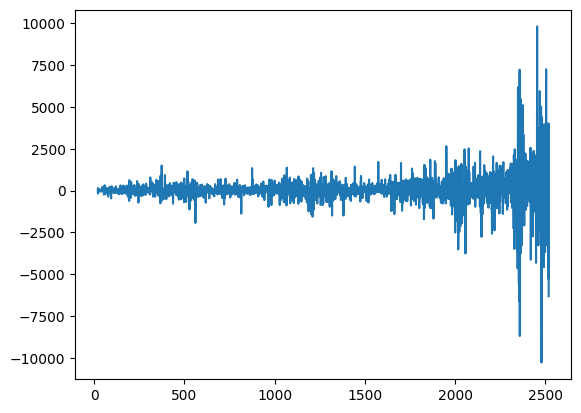

In [278]:
train_df.Profit.plot()

<Axes: >

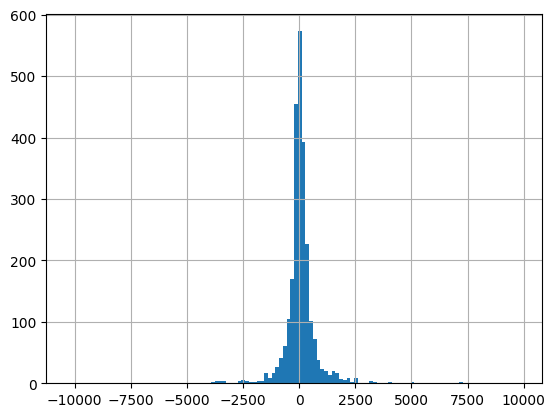

In [279]:
train_df.Profit.hist(bins= 120)

In [280]:
test_df['Profit'] = test_df.Close.diff() * units

In [281]:
test_df = test_df.drop(columns = ["Close"]).dropna()

In [282]:
test_df

,Date,Returns_binned,SMA_Ratio_binned,MACD_hist_binned,RSI_binned,SO_diff_binned,Profit
2520,2020-11-03 00:00:00-05:00,9,1,0,0,8,1630.226135
2521,2020-11-04 00:00:00-05:00,10,3,0,2,10,4402.526855
2522,2020-11-05 00:00:00-05:00,10,6,2,4,10,3982.780457
2523,2020-11-06 00:00:00-05:00,4,6,10,5,9,-132.019043
2524,2020-11-09 00:00:00-05:00,0,4,10,3,1,-2317.497253
...,...,...,...,...,...,...,...
3538,2024-11-20 00:00:00-05:00,6,5,10,5,8,720.001221
3539,2024-11-21 00:00:00-05:00,4,4,10,6,3,-479.995728
3540,2024-11-22 00:00:00-05:00,7,5,10,7,6,1349.990845
3541,2024-11-25 00:00:00-05:00,8,7,10,8,6,3000.000000


### Training an RL Agent witg Q-Tables

In [283]:
# train_df = train_df.drop(columns=['Close'])
train_df = train_df.drop(columns=['Close']).dropna()
train_df

,Date,Returns_binned,SMA_Ratio_binned,MACD_hist_binned,RSI_binned,SO_diff_binned,Profit
20,2010-11-29 00:00:00-05:00,7,6,5,3,8,56.335449
21,2010-11-30 00:00:00-05:00,1,3,5,3,1,-172.323227
22,2010-12-01 00:00:00-05:00,9,5,5,3,9,158.163071
23,2010-12-02 00:00:00-05:00,6,6,5,4,9,52.720070
24,2010-12-03 00:00:00-05:00,4,5,5,6,4,-21.388054
...,...,...,...,...,...,...,...
2514,2020-10-26 00:00:00-04:00,5,2,0,4,1,9.765625
2515,2020-10-27 00:00:00-04:00,8,3,0,4,8,1513.069153
2516,2020-10-28 00:00:00-04:00,0,1,0,2,2,-5271.324158
2517,2020-10-29 00:00:00-04:00,10,2,0,3,9,4021.804810


In [ ]:

# Parámetros
alpha = 0.1
gamma = 0.95
epsilon = 0.5

# Definición de las dimensiones de q_table
num_bins = (11, 11, 11, 11,11, 3, 3) # Espacio de acción
q_table = np.random.uniform(low=-1, high=1, size=num_bins)

def get_state(row):
    # Ajustamos a 7 dimensiones para que coincida con q_table
    return (
        int(row['Returns_binned']),
        int(row['SMA_Ratio_binned']),
        int(row['MACD_hist_binned']),
        int(row['RSI_binned']),
        int(row['SO_diff_binned']),       
        int(row['position'])
    )
            
def calculate_reward(position, Profit):
    if position == 2:
        return Profit
    elif position == 0:
        return -Profit
    else:
        return 0

# Variables iniciales
total_reward = 0
start_index = 0

data = train_df.iloc[start_index:].copy()
data['position'] = 1

# Verifica si la columna 'Profit' existe
if 'Profit' not in data.columns:
    raise ValueError("La columna 'Profit' no existe en train_df.")

row = data.iloc[0]

try:
    state = get_state(row)
except Exception as e:
    raise ValueError(f"Error al generar el estado inicial: {e}")

# Bucle principal
for step in range(len(data) - 1):
    # Selección de acción
    if np.random.rand() < epsilon:
        action = np.random.choice(3)
    else:
        action = np.argmax(q_table[state])

    next_position = action
    data.at[data.index[step + 1], 'position'] = next_position

    # Siguiente fila
    next_row = data.iloc[step + 1]

    # Cálculo de recompensa
    if 'Profit' not in next_row or np.isnan(next_row['Profit']):
        reward = 0
    else:
        reward = calculate_reward(next_row['position'], next_row['Profit'])

    # Obtener el siguiente estado
    try:
        next_state = get_state(next_row)
    except Exception as e:
        raise ValueError(f"Error al generar el siguiente estado: {e}")

    # Validar siguiente estado
    if not isinstance(next_state, tuple) or len(next_state) != len(num_bins):
        raise ValueError(f"Siguiente estado inválido: {next_state}. Esperado una tupla de {len(num_bins)} dimensiones.")

    # Actualización de Q-Table
    best_next_action = np.argmax(q_table[next_state])
    td_target = reward + gamma * q_table[next_state][best_next_action]
    q_table[state][action] += alpha * (td_target - q_table[state][action])

    total_reward += reward
    state = next_state


ValueError: Siguiente estado inválido: (1, 3, 5, 3, 1, 0). Esperado una tupla de 7 dimensiones.